In [1]:
%%html
<style>.container { width:80% !important; }

## <span style='font-family:Georgia'> Objectives
The purpose of this notebook is to try to extract features from audio data and to estimate the possibility of their inclusion in the considerations

## <span style='font-family:Georgia'> Libraries/dependencies:
* [SoX openSMILE dependency](http://sox.sourceforge.net/)
* [openSMILE documentation](https://audeering.github.io/opensmile-python/index.html)
* [Librosa documentation](https://librosa.org/doc/main/feature.html)

## <span style='font-family:Georgia'> Bibliography
* [Acoustic Parameters Explanation](https://ieeexplore.ieee.org/document/7160715)
* [PolEval2021 github](https://github.com/poleval/2021-punctuation-restoration)
    
    
*Author: Elżbieta Jowik*

In [2]:
import math
import timeit
import random
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import os, glob, pickle
from statistics import mode 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as ms
from IPython.display import display, Markdown, Audio

import opensmile
import librosa
import librosa.display
import soundfile
import python_speech_features
from scipy.signal.windows import hann
import torch

import warnings

random.seed(123)
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27), 'axes.facecolor':'white', 'axes.grid' : True, "grid.color": ".9"})
warnings.filterwarnings('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=70

SoX could not be found!

    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [3]:
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

## <span style='font-family:Georgia'> Audio data preview

In [4]:
audio_data_dir='../data/poleval_final_dataset_wav/train'
audio_paths=glob.glob(f"{audio_data_dir}\\*.wav")

features_data_dir='../data/poleval_final_dataset_wav/features'
features_paths=glob.glob(f"{features_data_dir}\\*.csv")

In [5]:
# list directory with audio data and check files volumes (the getsize function output is in bytes)
files_volumetric_dict={}
data_volume=0
for dirname, _, filenames in os.walk(audio_data_dir):
    for filename in filenames:
        fp=os.path.join(dirname, filename)
        audio_volume=os.path.getsize(fp)
        data_volume=data_volume+audio_volume
        files_volumetric_dict[fp]=audio_volume
        
display(Markdown(f'### Number of all audio files: {len(files_volumetric_dict.keys())}'))
display(Markdown(f'### Overall audio data volume: {convert_size(data_volume)}'))
display(Markdown(f'### Individual audio files volumes (in bytes):'))
files_volumetric_dict

### Number of all audio files: 800

### Overall audio data volume: 2.39 GB

### Individual audio files volumes (in bytes):

{'../data/poleval_final_dataset_wav/train\\wikinews178430.wav': 3530958,
 '../data/poleval_final_dataset_wav/train\\wikinews178747.wav': 2713038,
 '../data/poleval_final_dataset_wav/train\\wikinews178788.wav': 2492878,
 '../data/poleval_final_dataset_wav/train\\wikinews178804.wav': 3634638,
 '../data/poleval_final_dataset_wav/train\\wikinews178814.wav': 2231118,
 '../data/poleval_final_dataset_wav/train\\wikinews178860.wav': 4951758,
 '../data/poleval_final_dataset_wav/train\\wikinews179110.wav': 2628558,
 '../data/poleval_final_dataset_wav/train\\wikinews179114.wav': 3793998,
 '../data/poleval_final_dataset_wav/train\\wikinews179133.wav': 3385038,
 '../data/poleval_final_dataset_wav/train\\wikinews179145.wav': 4289358,
 '../data/poleval_final_dataset_wav/train\\wikinews179245.wav': 3031118,
 '../data/poleval_final_dataset_wav/train\\wikinews179551.wav': 2291610,
 '../data/poleval_final_dataset_wav/train\\wikinews179671.wav': 2151918,
 '../data/poleval_final_dataset_wav/train\\wikinews

In [6]:
converted_files_volumetric_dict={}
for fp, size in files_volumetric_dict.items():
    converted_files_volumetric_dict[fp]=convert_size(size)
    
converted_files_volumetric_dict

{'../data/poleval_final_dataset_wav/train\\wikinews178430.wav': '3.37 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews178747.wav': '2.59 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews178788.wav': '2.38 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews178804.wav': '3.47 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews178814.wav': '2.13 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews178860.wav': '4.72 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews179110.wav': '2.51 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews179114.wav': '3.62 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews179133.wav': '3.23 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews179145.wav': '4.09 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews179245.wav': '2.89 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews179551.wav': '2.19 MB',
 '../data/poleval_final_dataset_wav/train\\wikinews179671.wav': '2.05 MB',
 '../data/poleval_final_d

## <span style='font-family:Georgia'> Technical overview

### <span style='font-family:Georgia'> Audio volumetric distributions

<AxesSubplot:>

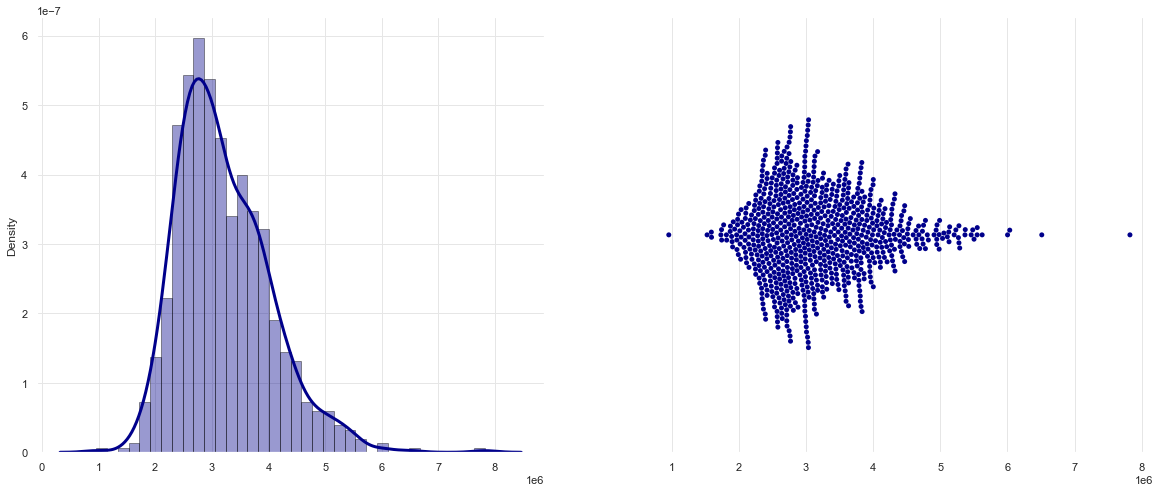

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

audio_volumes=list(files_volumetric_dict.values())

sns.distplot(audio_volumes, hist=True, kde=True, bins=int(180/5), color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 3}, ax=axes[0])
sns.swarmplot(audio_volumes, orient="v", color = 'darkblue', ax=axes[1])

In [8]:
# instantiate the main extractor class, Smile, with a configuration that includes formants and ComParE_2016 features set.
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

In [9]:
# load data & measure the average and total data loading time 

# Notes:
# performed once and commented out as the output feature frames were saved to csv files
# features extraction took over 4 hours 45 minutes

# features_frames_dict={}

# for fp in tqdm(audio_paths):
#     foo = %timeit -o smile.process_file(fp)
#     files_volumetric_dict[fp].append(foo)
#     df = smile.process_file(fp)
#     train_dir, fn = os.path.split(fp)
#     features_dir=train_dir.replace('train', 'features')
#     features_fn=fn.replace('wav', 'csv')
#     df.to_csv(os.path.join(features_dir, features_fn))
#     features_frames_dict[fp]=df

features_frames_dict={}

for fp in tqdm(features_paths):
    df=pd.read_csv(fp)
    features_frames_dict[fp]=df

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [01:34<00:00,  8.45it/s]


### <span style='font-family:Georgia'> Duration distributions

In [10]:
# list directory with audio data and check files volumes (the getsize function output is in bytes)
files_length_dict={}
overall_length=0
for fp in glob.glob(f"{audio_data_dir}\\*.wav"):
    sound_file=soundfile.SoundFile(fp)
    y = sound_file.read(dtype="float32")
    sr=sound_file.samplerate
    audio_length=librosa.get_duration(y, sr)
    overall_length=overall_length+audio_length
    files_length_dict[fp]=audio_length
        
display(Markdown(f'### Overall audio data length: {overall_length} s'))
display(Markdown(f'### Individual audio files lengths (in seconds):'))
files_length_dict

### Overall audio data length: 80183.40393749997 s

### Individual audio files lengths (in seconds):

{'../data/poleval_final_dataset_wav/train\\wikinews178430.wav': 110.34,
 '../data/poleval_final_dataset_wav/train\\wikinews178747.wav': 84.78,
 '../data/poleval_final_dataset_wav/train\\wikinews178788.wav': 77.9,
 '../data/poleval_final_dataset_wav/train\\wikinews178804.wav': 113.58,
 '../data/poleval_final_dataset_wav/train\\wikinews178814.wav': 69.72,
 '../data/poleval_final_dataset_wav/train\\wikinews178860.wav': 154.74,
 '../data/poleval_final_dataset_wav/train\\wikinews179110.wav': 82.14,
 '../data/poleval_final_dataset_wav/train\\wikinews179114.wav': 118.56,
 '../data/poleval_final_dataset_wav/train\\wikinews179133.wav': 105.78,
 '../data/poleval_final_dataset_wav/train\\wikinews179145.wav': 134.04,
 '../data/poleval_final_dataset_wav/train\\wikinews179245.wav': 94.72,
 '../data/poleval_final_dataset_wav/train\\wikinews179551.wav': 71.610375,
 '../data/poleval_final_dataset_wav/train\\wikinews179671.wav': 67.245,
 '../data/poleval_final_dataset_wav/train\\wikinews179742.wav': 86.

<AxesSubplot:>

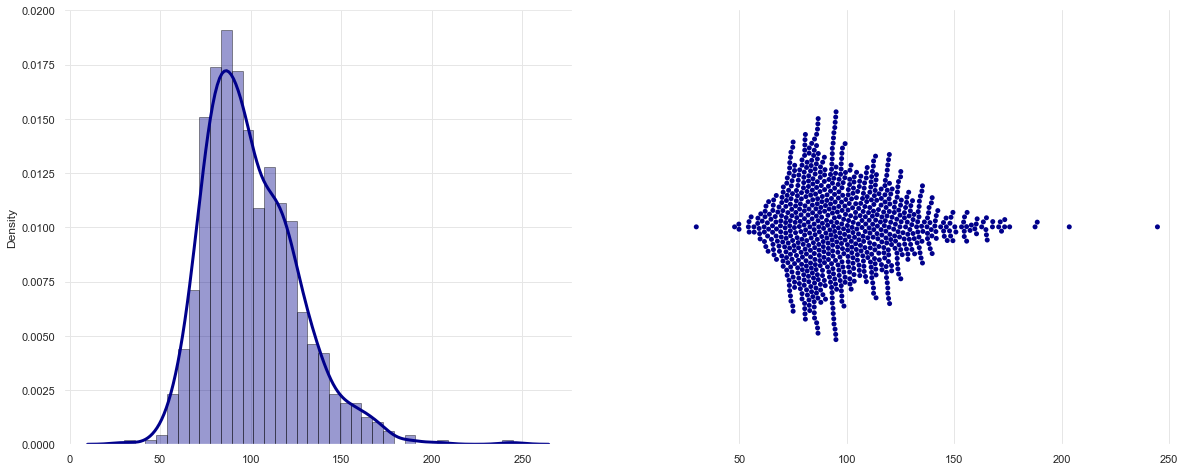

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

audio_lengths=list(files_length_dict.values())

sns.distplot(audio_lengths, hist=True, kde=True, bins=int(180/5), color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 3}, ax=axes[0])
sns.swarmplot(audio_lengths, orient="v", color = 'darkblue', ax=axes[1])

### <span style='font-family:Georgia'> Zeros percentage distribution (overall, features frames all together)

In [12]:
stats_summary=pd.DataFrame()
for fp, features_frame in tqdm(features_frames_dict.items()):
    _, fn = os.path.split(fp)
    fn=fn.strip(".csv")
    f_stats=pd.DataFrame(features_frame.isin([0]).sum(axis=0)/len(features_frame), columns=[fn])
    if stats_summary.shape == (0,0):
        stats_summary=f_stats
    stats_summary=stats_summary.merge(f_stats, how="left", left_index=True, right_index=True)

stats_summary=stats_summary.drop(["file", "start", "end"])

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [01:27<00:00,  9.10it/s]


In [13]:
# features that take only one value equal to 0
zeroed_columns=stats_summary.loc[(stats_summary==1).all(axis=1)].index
print(f"There are {len(zeroed_columns)} columns that are all zeroed in the features set.")
zeroed_columns

There are 0 columns that are all zeroed in the features set.


Index([], dtype='object')

In [14]:
# features that do not value equal to 0
no_zeros_columns=stats_summary.loc[(stats_summary==0).all(axis=1)].index
print(f"There are {len(no_zeros_columns)} columns that do not value equal to 0 in the features set.")
no_zeros_columns

There are 33 columns that do not value equal to 0 in the features set.


Index(['audspec_lengthL1norm_sma', 'audspecRasta_lengthL1norm_sma',
       'audSpec_Rfilt_sma[0]', 'audSpec_Rfilt_sma[1]', 'audSpec_Rfilt_sma[2]',
       'audSpec_Rfilt_sma[3]', 'audSpec_Rfilt_sma[4]', 'audSpec_Rfilt_sma[5]',
       'audSpec_Rfilt_sma[6]', 'audSpec_Rfilt_sma[7]', 'audSpec_Rfilt_sma[8]',
       'audSpec_Rfilt_sma[9]', 'audSpec_Rfilt_sma[10]',
       'audSpec_Rfilt_sma[11]', 'audSpec_Rfilt_sma[12]',
       'audSpec_Rfilt_sma[13]', 'audSpec_Rfilt_sma[14]',
       'audSpec_Rfilt_sma[15]', 'audSpec_Rfilt_sma[16]',
       'audSpec_Rfilt_sma[17]', 'audSpec_Rfilt_sma[18]',
       'audSpec_Rfilt_sma[19]', 'audSpec_Rfilt_sma[20]',
       'audSpec_Rfilt_sma[21]', 'audSpec_Rfilt_sma[22]',
       'audSpec_Rfilt_sma[23]', 'audSpec_Rfilt_sma[24]',
       'audSpec_Rfilt_sma[25]', 'pcm_fftMag_spectralRollOff25.0_sma',
       'pcm_fftMag_spectralRollOff50.0_sma',
       'pcm_fftMag_spectralRollOff75.0_sma',
       'pcm_fftMag_spectralRollOff90.0_sma', 'pcm_fftMag_spectralEntropy_sma'],


In [15]:
dist_plt_cols=stats_summary.loc[~stats_summary.index.isin(list(no_zeros_columns)+list(zeroed_columns))]

dist_plt_cols.shape[0]

32

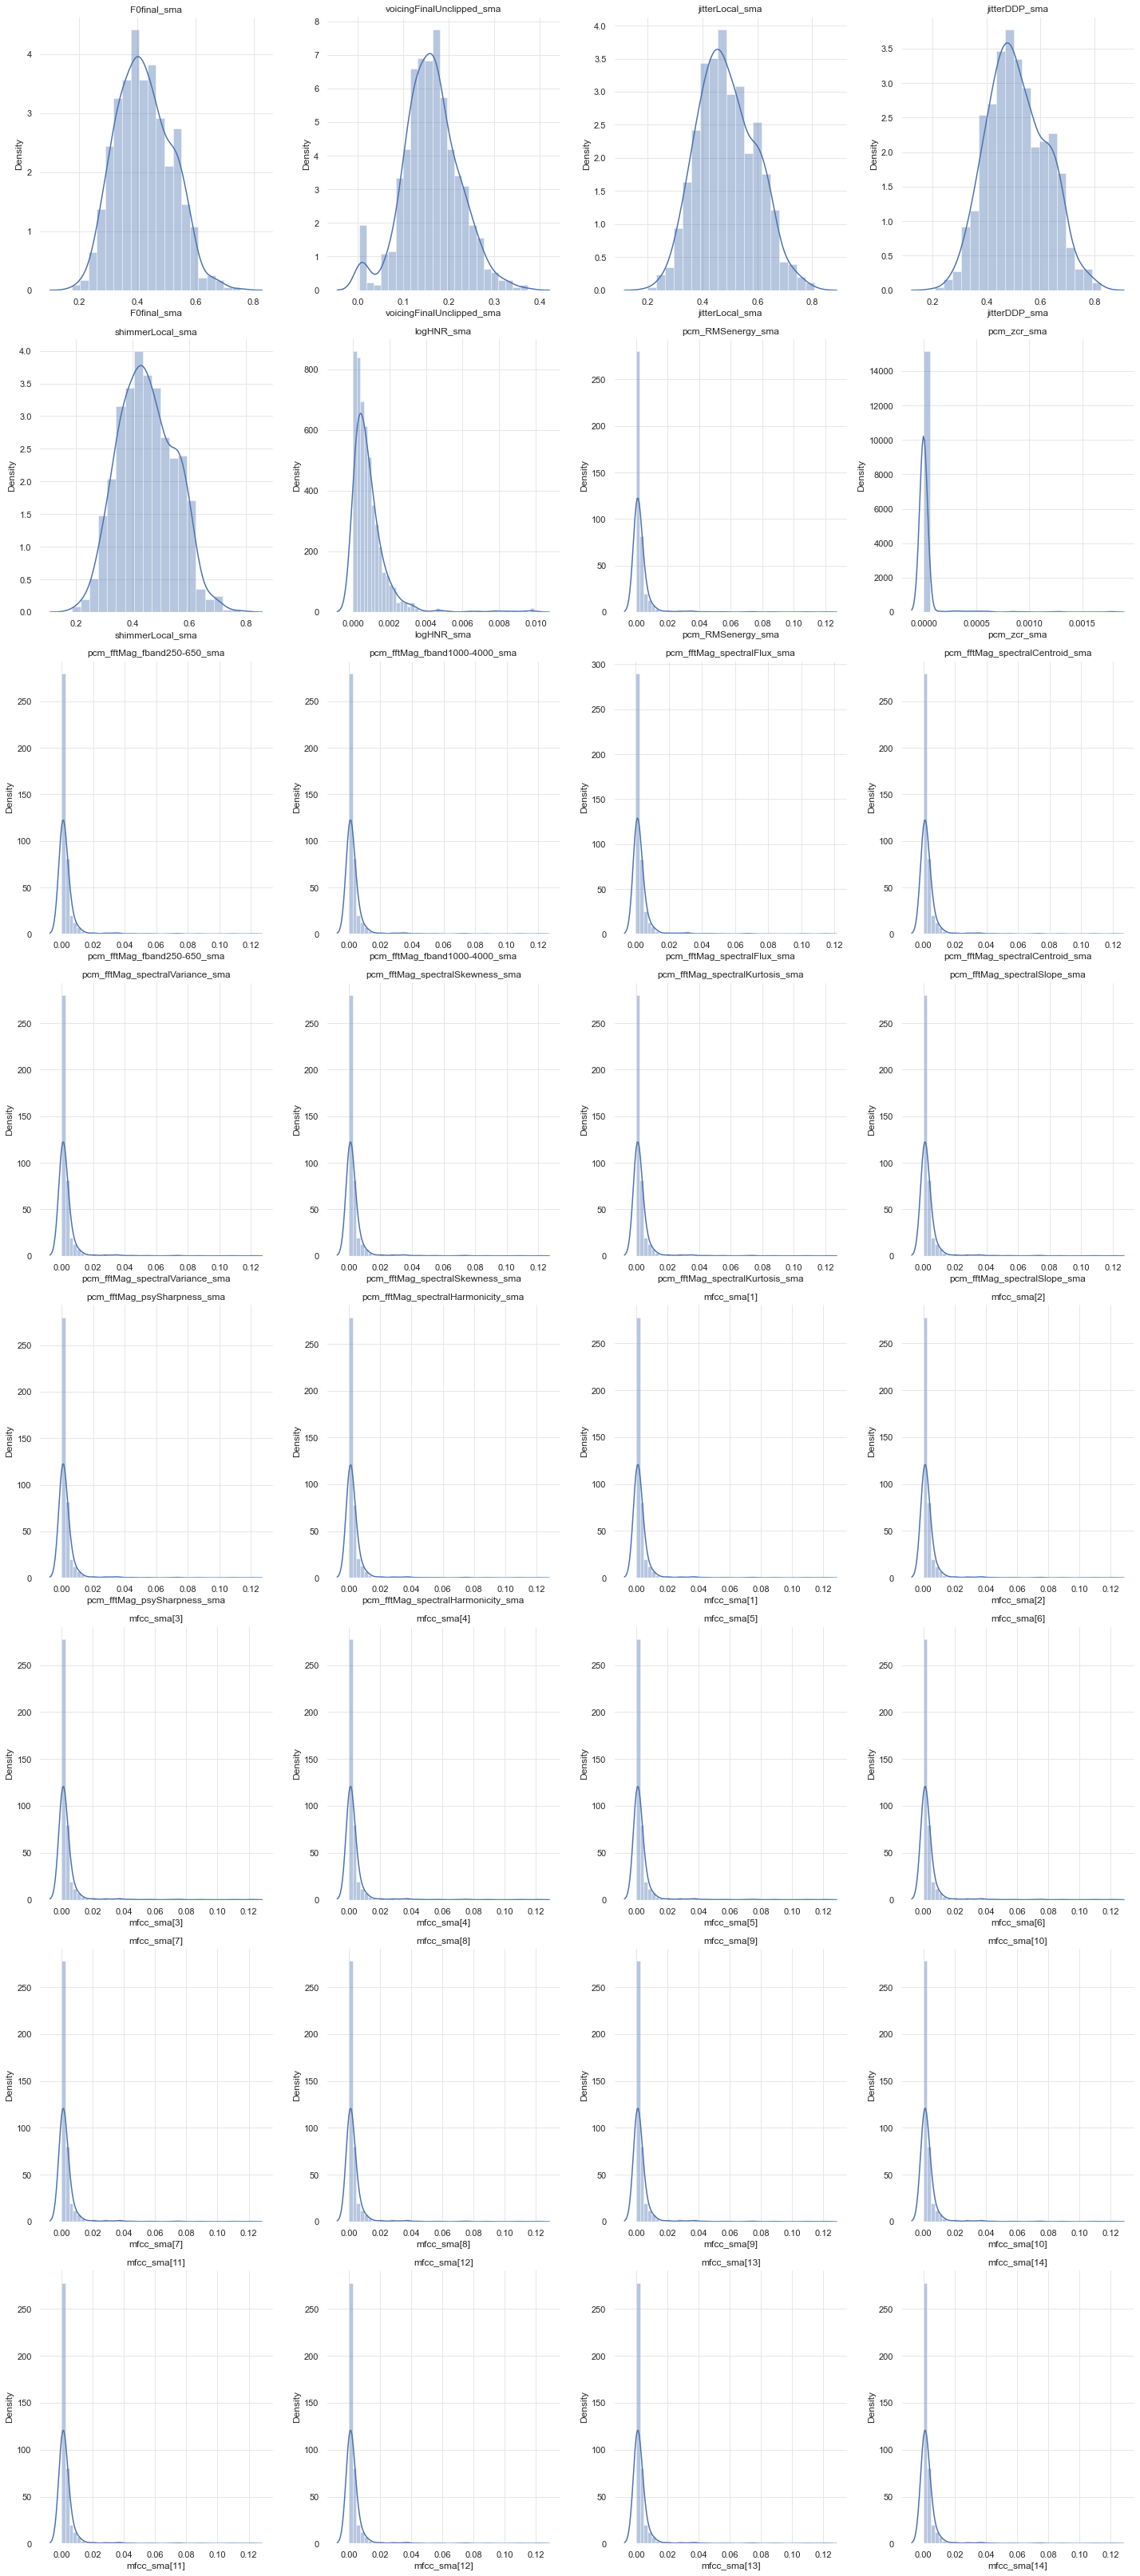

In [16]:
# Distributions of percentages of zeros in individual columns 
fig, axes = plt.subplots(nrows = 8, ncols = 4)
axes = axes.flatten()
fig.set_size_inches(20, 45)

for ax, col in zip(axes, dist_plt_cols.index):
    sns.distplot(stats_summary.loc[col], ax = ax)
    ax.set_title(col)
    
plt.tight_layout()
plt.show()

## <span style='font-family:Georgia'> Exemplary audio OpenSMILE & Librosa features extraction and preview

In [17]:
# select one file as example
foo=[]
for k, v in files_length_dict.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if v == mode(list(files_length_dict.values())):
        foo.append(k)

testfp=random.choice(foo)
sound_file=soundfile.SoundFile(testfp)
y = sound_file.read(dtype="float32")
sr=sound_file.samplerate
hop_length = 512

In [18]:
display(Audio(filename=testfp, autoplay=False))

In [19]:
test_path=testfp.replace('train', 'features').replace('.wav', '.csv')
test_features_frame=pd.read_csv(test_path)
test_features_frame.head(5)

file                   start  \
0  ../data/poleval_final_dataset_wav/train\wikine...         0 days 00:00:00   
1  ../data/poleval_final_dataset_wav/train\wikine...  0 days 00:00:00.010000   
2  ../data/poleval_final_dataset_wav/train\wikine...  0 days 00:00:00.020000   
3  ../data/poleval_final_dataset_wav/train\wikine...  0 days 00:00:00.030000   
4  ../data/poleval_final_dataset_wav/train\wikine...  0 days 00:00:00.040000   

                      end  F0final_sma  voicingFinalUnclipped_sma  \
0  0 days 00:00:00.060000          0.0                        0.0   
1  0 days 00:00:00.070000          0.0                        0.0   
2  0 days 00:00:00.080000          0.0                        0.0   
3  0 days 00:00:00.090000          0.0                        0.0   
4  0 days 00:00:00.100000          0.0                        0.0   

   jitterLocal_sma  jitterDDP_sma  shimmerLocal_sma  logHNR_sma  \
0              0.0            0.0               0.0      -100.0   
1              0.0            0.0               0.0      -100.0   
2              0.0            0.0               0.0      -100.0   
3              0.0            0.0               0.0      -100.0   
4              0.0            0.0               0.0      -100.0   

   audspec_lengthL1norm_sma  audspecRasta_lengthL1norm_sma  pcm_RMSenergy_sma  \
0                  0.001034                       0.988341                0.0   
1                  0.001034                       0.988341                0.0   
2                  0.001034                       0.988341                0.0   
3                  0.001034                       0.988341                0.0   
4                  0.001034                       0.988341                0.0   

   pcm_zcr_sma  audSpec_Rfilt_sma[0]  audSpec_Rfilt_sma[1]  \
0     0.997917              0.129216              0.272048   
1     0.997917              0.129216              0.272048   
2     0.997917              0.129216              0.272048   
3     0.997917              0.129216              0.272048   
4     0.997917              0.129216              0.272048   

   audSpec_Rfilt_sma[2]  audSpec_Rfilt_sma[3]  audSpec_Rfilt_sma[4]  \
0              0.419528              0.554447              0.669729   
1              0.419528              0.554447              0.669729   
2              0.419528              0.554447              0.669729   
3              0.419528              0.554447              0.669729   
4              0.419528              0.554447              0.669729   

   audSpec_Rfilt_sma[5]  audSpec_Rfilt_sma[6]  audSpec_Rfilt_sma[7]  \
0              0.765896              0.847028              0.917829   
1              0.765896              0.847028              0.917829   
2              0.765896              0.847028              0.917829   
3              0.765896              0.847028              0.917829   
4              0.765896              0.847028              0.917829   

   audSpec_Rfilt_sma[8]  audSpec_Rfilt_sma[9]  audSpec_Rfilt_sma[10]  \
0              0.982249              1.043099               1.102099   
1              0.982249              1.043099               1.102099   
2              0.982249              1.043099               1.102099   
3              0.982249              1.043099               1.102099   
4              0.982249              1.043099               1.102099   

   audSpec_Rfilt_sma[11]  audSpec_Rfilt_sma[12]  audSpec_Rfilt_sma[13]  \
0                1.16007               1.217131               1.272837   
1                1.16007               1.217131               1.272837   
2                1.16007               1.217131               1.272837   
3                1.16007               1.217131               1.272837   
4                1.16007               1.217131               1.272837   

   audSpec_Rfilt_sma[14]  audSpec_Rfilt_sma[15]  audSpec_Rfilt_sma[16]  \
0               1.326212               1.375581               1.418057   
1        

#### <span style='font-family:Georgia'>Features Explanation:
* `F0final_sma` - F0 Harmonics ratios; a measure for the degree of harmonicity contained in a signal. 
* `voicingFinalUnclipped_sma` - speker voicing-related feature (unclipped means of the voicing probability of the nal fundamental frequency candidate)
* `jitterLocal_sma`, `jitterDDP_sma` - voice-quality related features, jitter is defined as the parameter of frequency variation from cycle to cycle
* `shimmerLocal_sma` - voice-quality related feature, shimmer relates to the amplitude variation of the sound wave (amplitude deviations between pitch periods). 
* `logHNR_sma` - the log of the ratio of the energy of harmonic signal components to the energy of noise like signal components, the HNR is an assessment of the ratio between periodic components and non periodic component comprising a segment of voiced speech. 
* `audspec_lengthL1norm_sma`, `audspecRasta_lengthL1norm_sma`, `audSpec_Rfilt_sma` - auditory spectrum related features where auditory spectrum is the range of frequency that is possible for the ear to detect. 
* `pcm_RMSenergy_sma` - energy of a speech signal
* `pcm_zcr_sma` - zero-crossing rate of time signal (frame-based), defined as the number of times the speech signal changes it polarity  
* `pcm_fftMag_fband250-650_sma`, `pcm_fftMag_fband1000-4000_sma`, `pcm_fftMag_spectralRollOff25.0_sma`, `pcm_fftMag_spectralRollOff50.0_sma`, `pcm_fftMag_spectralRollOff75.0_sma`, `pcm_fftMag_spectralRollOff90.0_sma`, `pcm_fftMag_spectralFlux_sma`,  `pcm_fftMag_spectralCentroid_sma`, `pcm_fftMag_spectralEntropy_sma`, `pcm_fftMag_spectralVariance_sma`, `pcm_fftMag_spectralSkewness_sma`, `pcm_fftMag_spectralKurtosis_sma`, `pcm_fftMag_spectralSlope_sma` `pcm_fftMag_psySharpness_sma`, `pcm_fftMag_spectralHarmonicity_sma` - spectral features (arbitrary band energies, roll-off points, centroid, entropy, maxpos, minpos, variance (= spread), skewness, kurtosis, slope) 
* `mfcc_sma` - Mel-Frequency cepstral coefficients, MFCC captures characteristics give reasonably good performance for speech recognition, speaker recognition, language identification and even accent identification. However, it is not very robust to noise. 

### <span style='font-family:Georgia'> Waveform & Autocorrelations

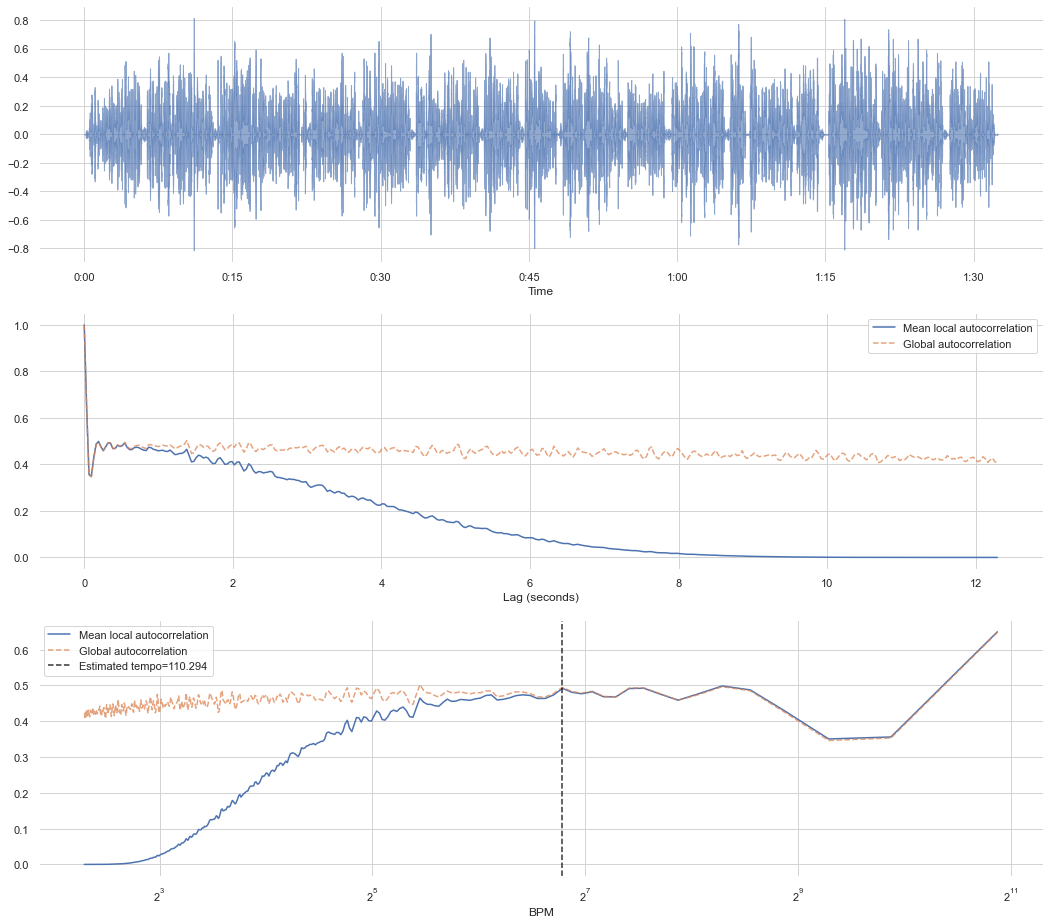

In [20]:
oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr, hop_length=hop_length)
# Compute global onset autocorrelation
ac_global = librosa.autocorrelate(oenv, max_size=tempogram.shape[0])
ac_global = librosa.util.normalize(ac_global)
# Estimate the global tempo for display purposes
tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr, hop_length=hop_length)[0]

# Plot
fig, ax = plt.subplots(nrows=3, figsize=(18, 16))

librosa.display.waveshow(y, sr=sr, ax=ax[0], alpha=0.6)
ax[0].grid(True, color='lightgrey')

x = np.linspace(0, tempogram.shape[0] * float(hop_length) / sr,
                num=tempogram.shape[0])
ax[1].plot(x, np.mean(tempogram, axis=1), label='Mean local autocorrelation')
ax[1].plot(x, ac_global, '--', alpha=0.75, label='Global autocorrelation')
ax[1].set(xlabel='Lag (seconds)')
ax[1].legend(frameon=True)
ax[1].grid(True, color='lightgrey')

freqs = librosa.tempo_frequencies(tempogram.shape[0], hop_length=hop_length, sr=sr)
ax[2].semilogx(freqs[1:], np.mean(tempogram[1:], axis=1),
         label='Mean local autocorrelation', base=2)
ax[2].semilogx(freqs[1:], ac_global[1:], '--', alpha=0.75,
             label='Global autocorrelation', base=2)
ax[2].axvline(tempo, color='black', linestyle='--', alpha=.8,
            label='Estimated tempo={:g}'.format(tempo))
ax[2].legend(frameon=True)
ax[2].set(xlabel='BPM')
ax[2].grid(True, color='lightgrey')

### <span style='font-family:Georgia'> Chromagram & Constant-Q chromagram

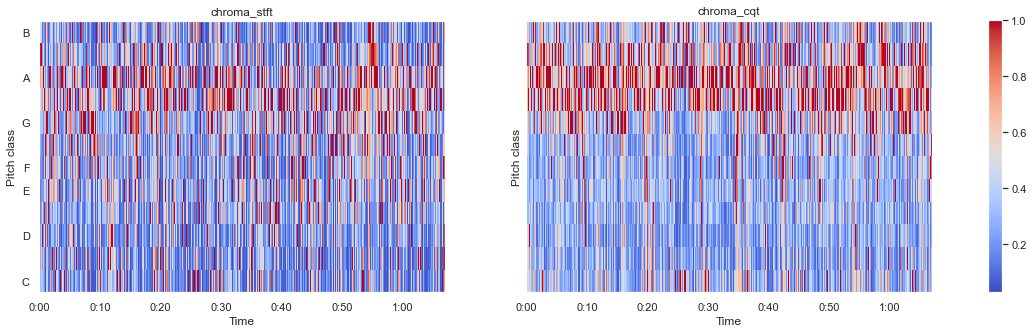

In [21]:
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,5))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time', ax=ax[0], cmap='coolwarm')
ax[0].set(title='chroma_stft')
ax[0].label_outer()
img = librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time', ax=ax[1], cmap='coolwarm')
ax[1].set(title='chroma_cqt')
fig.colorbar(img, ax=ax)

### <span style='font-family:Georgia'> Root-Mean-Square Energy (RMSE) & Spectrograms

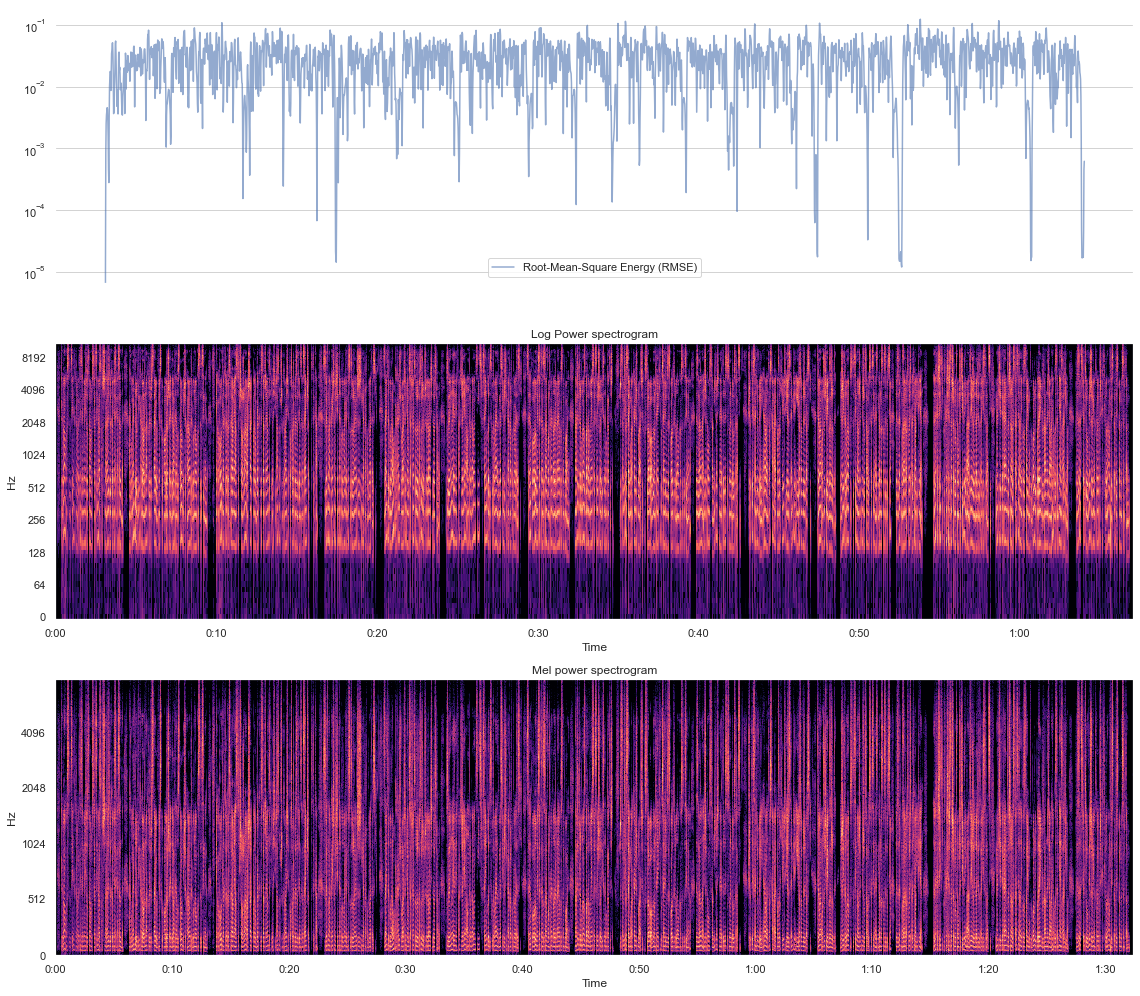

In [22]:
S, phase = librosa.magphase(librosa.stft(y))
rms = librosa.feature.rms(S=S)
fig, ax = plt.subplots(nrows=3, figsize=(16, 14), sharex=False)

times = librosa.times_like(rms)
log_S = librosa.amplitude_to_db(S, np.max)

ax[0].semilogy(times, rms[0], label='Root-Mean-Square Energy (RMSE)', alpha=0.6)
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
ax[0].grid(True, color='lightgrey')

img=librosa.display.specshow(log_S, y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Log Power spectrogram')
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False))[0]
librosa.feature.rms(S=S)

# Let's make and display a mel-scaled power (energy-squared) spectrogram
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', ax=ax[2])
plt.title('Mel power spectrogram')
plt.tight_layout()
plt.show()

### <span style='font-family:Georgia'> MFCC
    
*Note: There is no single definition of the mel scale. Librosa implement two ways: Slaney and HTK. Other packages might use different definitions, leading to different results.*

In [23]:
n_mfcc = 13
n_mels = 40
n_fft = 512 
hop_length = 160
fmin = 0
fmax = None
sr = 16000
n0,n1=1000,1500  # zoom
feature = 3  # play with this

#### <span style='font-family:Georgia'> Different MFCC implementations comparison
*The 0th feature still has severe unexplained offsets, and the higher features tend to drift away from each other. This may be something as simple as different implementations under the hood or slightly different numerical stability constants, or it might be something that can be fixed with fine tuning, like a choice of padding or perhaps a reference in a decibel conversion somewhere.*

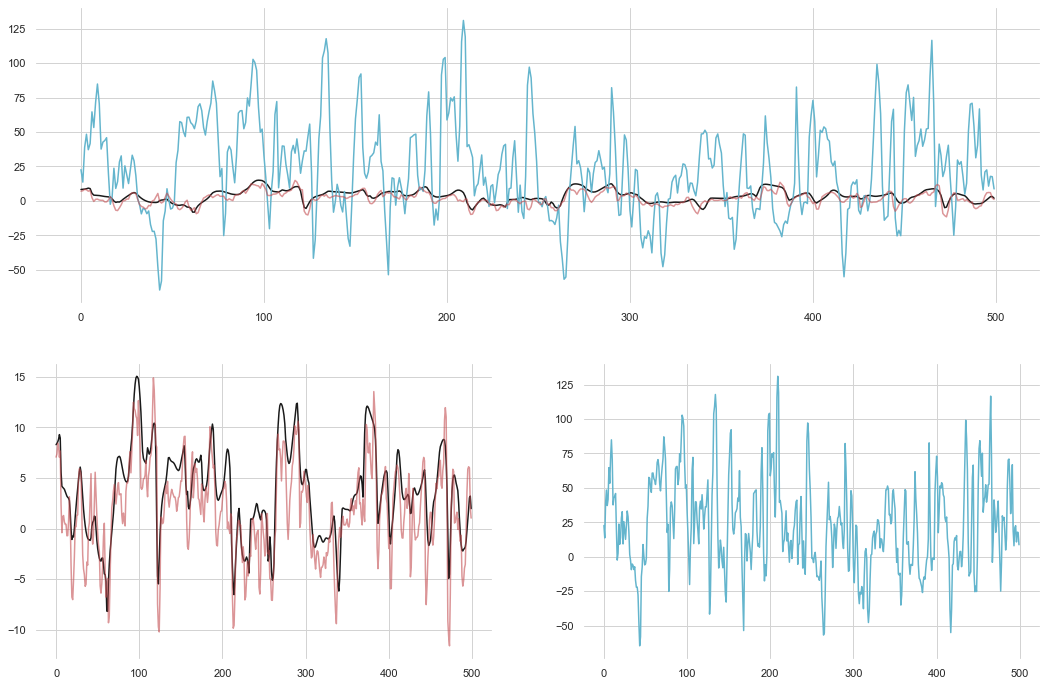

In [24]:
melkwargs={"n_fft" : n_fft, "n_mels" : n_mels, "hop_length":hop_length, "f_min" : fmin, "f_max" : fmax}

# Default librosa with db mel scale 
mfcc_lib_db = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft,
                                    n_mfcc=n_mfcc, n_mels=n_mels,
                                    hop_length=hop_length,
                                    fmin=fmin, fmax=fmax, htk=False)

# Nearly identical to above
mfcc_lib_db = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc, htk=False)

# Modified librosa with log mel scale (helper)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmin=fmin, 
                                    fmax=fmax, hop_length=hop_length)

# Modified librosa with log mel scale
mfcc_lib_log = librosa.feature.mfcc(S=np.log(S+1e-6), n_mfcc=n_mfcc, htk=False)

# Python_speech_features 
mfcc_speech = python_speech_features.mfcc(signal=y, samplerate=sr, winlen=n_fft / sr, winstep=hop_length / sr,
                                          numcep=n_mfcc, nfilt=n_mels, nfft=n_fft, lowfreq=fmin, highfreq=fmax,
                                          preemph=0.0, ceplifter=0, appendEnergy=False, winfunc=hann)

plt.figure(figsize=(18, 12))

plt.subplot(2, 1, 1)
plt.plot(mfcc_lib_log.T[:,feature][n0:n1], 'k')
plt.plot(mfcc_lib_db.T[:,feature][n0:n1], 'c')
plt.plot(mfcc_speech[:,feature][n0:n1], 'r', alpha=0.6)
plt.grid(True, color='lightgrey')

plt.subplot(2, 2, 3)
plt.plot(mfcc_lib_log.T[:,feature][n0:n1], 'k')
plt.plot(mfcc_speech[:,feature][n0:n1], 'r', alpha=0.6)
plt.grid(True, color='lightgrey')

plt.subplot(2, 2, 4)
plt.plot(mfcc_lib_db.T[:,feature][n0:n1], 'c')
plt.grid(True, color='lightgrey')

#### <span style='font-family:Georgia'> Compute MFCC deltas, delta-deltas

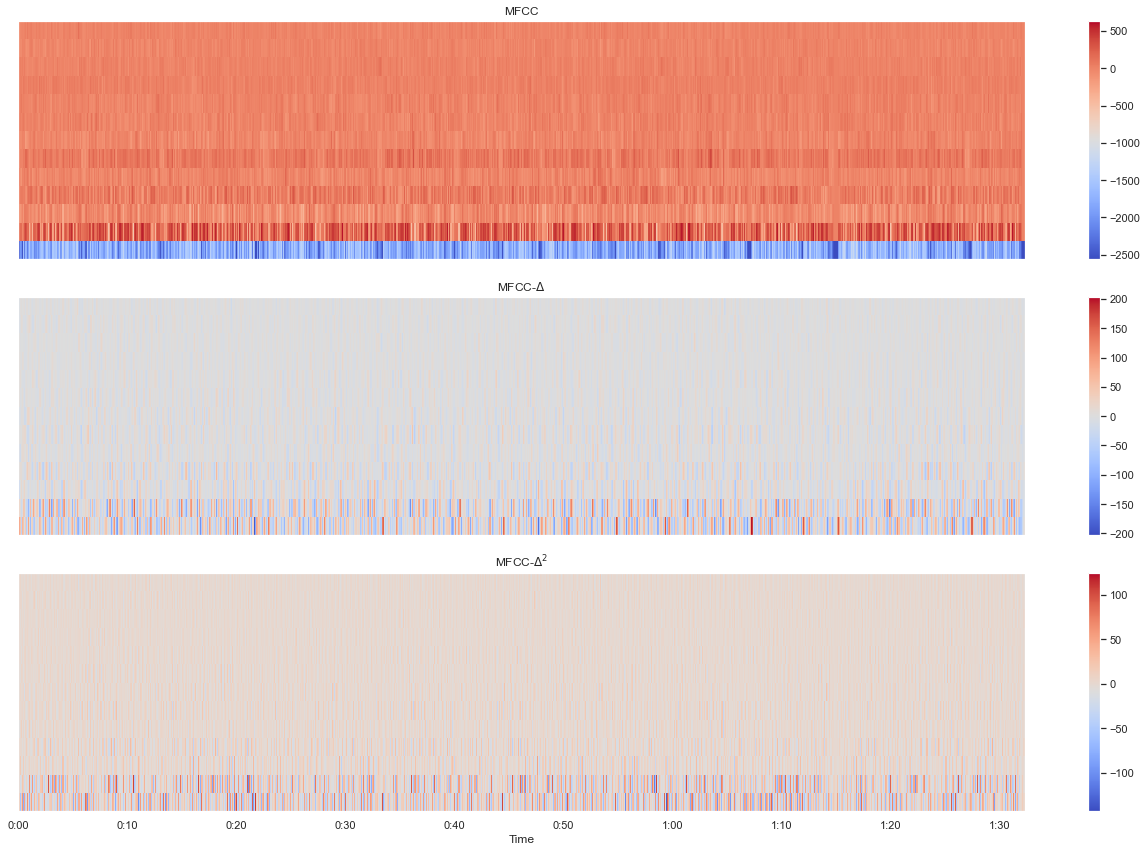

In [25]:
# Mel-frequency cepstral coefficients (MFCCs)
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=n_mfcc)

# Padding first and second deltas
delta_mfcc  = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(18, 12))

plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()

plt.subplot(3,1,2)
librosa.display.specshow(delta_mfcc)
plt.title('MFCC-$\Delta$')
plt.colorbar()

plt.subplot(3,1,3)
librosa.display.specshow(delta2_mfcc, sr=sr, x_axis='time')
plt.title('MFCC-$\Delta^2$')
plt.colorbar()

plt.tight_layout()